# Package installation

Your first task this time is actually the installation of a package. Try running the cell below, it will probably fail with an `ModuleNotFoundError`. This is because you haven't installed the pybaseball package yet with the plain installation of anaconda. Also it's not a package that's available via any conda channel, so you will have to use the standard-installer pip.

Run ```pip install pybaseball``` in your terminal and try importing the packages again

In [1]:
import pybaseball
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Your own support vector machine

Today's practice will deal with support vector machines. Using radial basis functions(RBF) as kernel functions we will analyze everyones' favorite sport: baseball! Due to its popularity you are obviously already familiar with the fact, that the [strike zone](https://de.wikipedia.org/wiki/Strike_Zone), which the pitcher has to hit in order to be awarded a "strike" against the batter and will otherwise be punished with a "ball", is defined as a rectangle reaching from the player's knees to his chest above the home base. Because this is common knowledge we don't need to mention, that this definition varies from player to player as a result and also the umpire's calls will impact the shape of the real shape of the strike zone. We will build a support vector machine for our favorite players to determine the decision boundary for the judgment, if a pitch will be a strike or a ball.

The player, who we'll have a look at, is the 2017 rookie of the year, Aaron Judge, who's 2.01m tall and therefore one of the tallest players in the MLB. Let's see what information is available.

In [22]:
judge_id = pybaseball.playerid_lookup("Judge","Aaron")
judge_stats = pybaseball.statcast_batter('2010-01-01', '2023-01-01', judge_id["key_mlbam"].iloc[0])
print(judge_stats.columns)

Gathering Player Data


C:\Users\lukas\miniconda3\lib\site-packages\ipykernel_launcher.py:2: DtypeWarning: Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.
  


Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

### Data exploration

Well this might be a little too much data for now, even for us baseball enthusiasts. If you really want to know what all of these stats mean, I'll refer you to [this site](https://baseballsavant.mlb.com/csv-docs).

For now I'll go ahead and pick the relevant columns for now.

In [23]:
judge_df = judge_stats[["plate_x", "plate_z", "type"]].copy()
print(judge_df[100:106])

    plate_x  plate_z type
30     0.26     1.81    X
31     0.57     1.66    S
32     0.89     0.96    B
33     0.34     2.74    S
34     0.64     3.88    S
35     1.11     2.45    B


There we go, this is the horizontal(plate_x) and vertical(plate_z) position of the ball when it crosses home plate from the catcher's perspective and whether the pitch resulted in a strike(**S**), ball(**B**) or a successful hit(**X**), but wait... this was too easy. Something feels off.

What's that "mixed types"-error message in cell number 2 about? Why would I show you the columns 100 to 105 and not simply df.head()? Also if I print columns 100 to 105, why does the index in the output say 30 to 35?

Another problem might lure in the "type" column. What datatype is it? Why might this be a problem and what would we rather have? 

Inspect the data yourself and figure out the problems

In [24]:
print(judge_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15156 entries, 0 to 3202
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   plate_x  14611 non-null  float64
 1   plate_z  14611 non-null  float64
 2   type     15156 non-null  object 
dtypes: float64(2), object(1)
memory usage: 473.6+ KB
None


### Data preparation

Firstly there is a bunch of NaNs in our data. Secondly SVMs are good with numerical data, but not with categorical data as they want to represent the data as vectors.

So we want to map our data to 0s for balls and 1s for strikes. The **map-method** of dataframes comes in super handy for this kind of task. As we are mostly interested in the umpire's decision we will ignore the balls, which went into play. They will turn into NaNs, which we still have to deal with anyway because of the first problem.

Create a new column called `"label"` in the dataframe, which maps balls and strikes to their respective value and makes NaNs out of successful hits to pass the test cell.

In [25]:
judge_df["label"] = judge_df["type"].map({"B": 0, "S": 1})
print(judge_df.head())

   plate_x  plate_z type  label
0      NaN      NaN    X    NaN
1      NaN      NaN    S    1.0
2      NaN      NaN    S    1.0
3      NaN      NaN    S    1.0
4      NaN      NaN    B    0.0


In [96]:
# Test cell

assert judge_df.get("label") is not None, 'No column called "label" exists in judge_df'
assert judge_df["label"].dtype in (int, float), "Data type of the label column should be a numerical data type"
np.testing.assert_equal(judge_df["label"].unique(), np.array([np.nan,  1.,  0.]), "Unique value of the label column should be [nan,  1.,  0.] in this order")

Now there is a bunch of NaNs in our data. We should decided what we want to do with these values. If there is some other relevant data in these rows, we might want to replace them with some other value. But in our case we have no reason to keep these rows, so we can just drop them.

Clean the data, so that there are no NaNs left.

Save the clean df to a variable called `judge_df_cleaned` to pass the test cell.

In [27]:
judge_df_cleaned = judge_df.dropna(axis=0)
print(judge_df_cleaned.head())

   plate_x  plate_z type  label
1     1.06     3.01    S    1.0
2     0.65     3.17    S    1.0
5    -0.34     2.00    S    1.0
7     0.68     2.49    S    1.0
8     0.07     2.20    S    1.0


In [82]:
# Test cell

assert not judge_df_cleaned.isnull().values.any(), "There are still NaNs left in your cleaned dataframe"
assert len(judge_df_cleaned) >= 12704, "There are less rows than expected in your data frame"
assert len(judge_df_cleaned) <= 12704, "There are more rows than expected in your data frame"

Let's have a look at how our data actually looks like. I prepared a plot-function for you. Call it(```my_function(my_argument1, my_argument2,...)```) with your dataframe(containing the mapped values in a column called *labels*) as the only argument

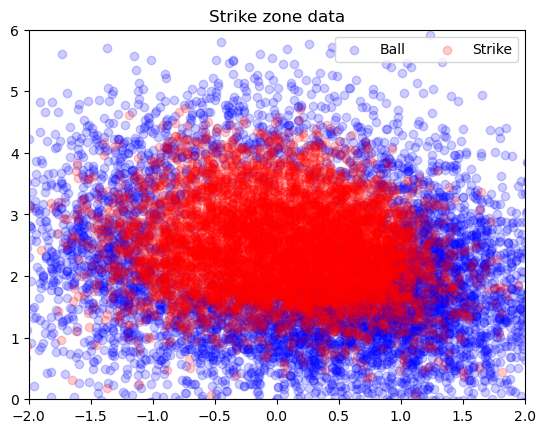

In [28]:
def plot_data(df):
    balls = df[df.label == 0]
    strikes = df[df.label == 1]
    
    fig, ax = plt.subplots()
    ball_scatter = plt.scatter(balls.plate_x, balls.plate_z, c="b", alpha=0.2)
    strike_scatter = plt.scatter(strikes.plate_x, strikes.plate_z, c="r", alpha=0.2)
    plt.title("Strike zone data")
    plt.legend((ball_scatter, strike_scatter),
           ('Ball', 'Strike'),
           loc='upper right',
           ncol=2,
           fontsize=10)
    ax.set_ylim(0, 6)
    ax.set_xlim(-2, 2)
    plt.show()

plot_data(judge_df_cleaned)

We now have a clean and handy dataframe with all the data, that we're interested in. Let's get ready to feed it into our SVM.

Assign the part of the dataframes, which we will use to predict the label, to a new variable called `features`. Also assign the column with the labels to a new variable called `labels`.

Remind yourself, that you already had to assign a subframe in a previous exercise.

In [29]:
features = judge_df_cleaned[["plate_x", "plate_z"]]
labels = judge_df_cleaned["label"]

print(features.head())
print(labels.head())

   plate_x  plate_z
1     1.06     3.01
2     0.65     3.17
5    -0.34     2.00
7     0.68     2.49
8     0.07     2.20
1    1.0
2    1.0
5    1.0
7    1.0
8    1.0
Name: label, dtype: float64


In [98]:
# Test cell

assert features.columns.to_list() == ["plate_x", "plate_z"], "The plate x and z data should be in the features"
assert labels.name == "label", "The label column could be the labels variable"

We want to test the quality of your model independently later on, so we will split our data in a training-set and a test-set again. Use the appropiate function a split your data. The test-set should contain 20% of the total data. Make sure, that the data was split correctly by having a look at the shape of the resulting matrices/arrays.

Assign features and labels of your subsets to the variables `features_train, features_test, labels_train, labels_test`. To pass the test cell the sample size and amount of features has to be correct.

In [99]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2)

print("features shape:", features.shape)
print("features_train shape:", features_train.shape)
print("features_test shape:", features_test.shape)

print("labels shape:", labels.shape)
print("labels_train shape:", labels_train.shape)
print("labels_test shape:", labels_test.shape)


features shape: (12704, 2)
features_train shape: (10163, 2)
features_test shape: (2541, 2)
labels shape: (12704,)
labels_train shape: (10163,)
labels_test shape: (2541,)


In [101]:
# Test cell

assert labels_train.shape == (10163,), "Your training set does not contain 80% of the data"
assert labels_test.shape == (2541,), "Your test set does not contain 20% of the data"

assert features_train.shape[0] == 10163, "Your training set does not contain 80% of the data"
assert features_test.shape[0] == 2541, "Your test set does not contain 20% of the data"
assert len(features_train.shape) == 2, "Your training set is not a 2D-Matrix"
assert len(features_test.shape) == 2, "Your test set is not a 2D-Matrix"
if (len(features_train.shape) == 2) and (len(features_test.shape) == 2):
    assert features_train.shape == (10163, 2), "Your training set does not contain all 2 features of the dataset"
    assert features_test.shape == (2541, 2), "Your test set does not contain all 2 features of the dataset"

### Model training

Now it's finally time to create our model, train it with our data, predict our test-set and evaluate the models accuracy. Use an `rbf-kernel`, `C = 2`, and `gamma = 2` for now.

Save the model to a variable called `model`, use the appropiate hyper parameters and fit the model to pass the test cell.

In [114]:
model = SVC(kernel = "rbf", C=2, gamma=2)
model.fit(features_train, labels_train)
test_prediction = model.predict(features_test)

print(f"Accuracy: {metrics.accuracy_score(test_prediction, labels_test): .2f}")
print(f"Accuracy: {model.score(features_test, labels_test): .2f}")

Accuracy:  0.86
Accuracy:  0.86


In [115]:
# Test cell

assert model.kernel == "rbf", 'The model kernel should be "rbf"'
assert model.C == 2, "The C hyper parameter should be 2"
assert model.gamma == 2, "The gamma hyper parameter should be 2"
try:
    model.fit_status_
except:
    raise AssertionError("The model is not fitted")

Also print the confusion-matrix of your predictions as an assessment of the model-performance. Don't forget that labels you want to display are is the list ["Balls", "Strikes"].

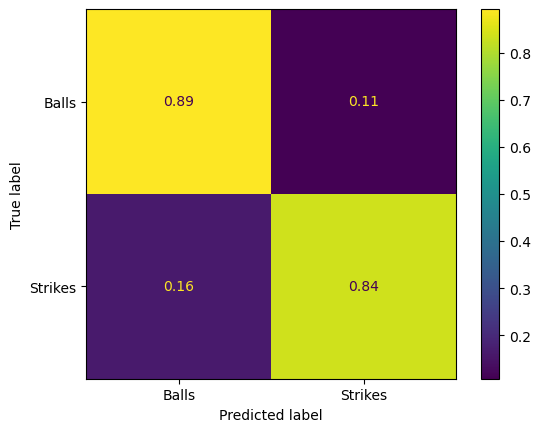

In [116]:
cm = confusion_matrix(labels_test, test_prediction, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Balls", "Strikes"])
disp.plot()
plt.show()

As a final reward you get to plot the decision boundary. Call the ```plot_strike_zone```-function with your cleaned dataframe and your trained model.

C:\Users\lukas\miniconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


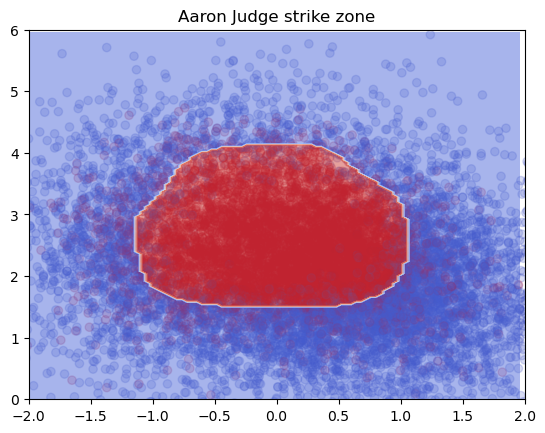

In [117]:
def plot_strike_zone(df, model):
    fig, ax = plt.subplots()
    plt.scatter(df.plate_x, df.plate_z, c=df.label, cmap=plt.cm.coolwarm, alpha=0.2)
    plt.title("Aaron Judge strike zone")
    ax.set_ylim(0, 6)
    ax.set_xlim(-2, 2)
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    h = 0.04
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
    plt.show()
    
plot_strike_zone(judge_df_cleaned, model)

**Congratulations on building your own SVM model!**

If your thirst for baseball data is still not quenched(understandably), feel free to compare Judge's strike zone to that of a smaller player like Jose Altuve.